# Data Clustering

### Setup

In [1]:
import numpy as np

# Data generation
from sklearn.datasets import make_blobs, make_moons

# Clustering algorithms and evaluation metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.neighbors import NearestNeighbors

#Visualization
import matplotlib.pyplot as plt
import matplotlib as mp
from IPython.display import Image
%matplotlib inline

# Grouping objects by similarity using k-means

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of $N$ samples $X$ into $k$ disjoint clusters $C$, each $\mu_j$ described by the mean  of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from $X$, although they live in the same space.

The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion:

$$ \sum_{i=1}^{K}\sum_{x_j \in C_{i}}||x_j - \mu_{i}||^2
$$

Inertia can be recognized as a measure of how internally coherent clusters are.

**Algorithm**: 
1) Place the centroids randomly. 
2) Label the instances - label of the closest centroid 
3) update the centroids and go to 2  until the centroids stop moving 

The algorithm is guaranteed to converge in a finite number of steps. But, it may not converge to the right solution:  it depends on the centroid initialization.

## Main features
- you have to specify the number of clusters k;
- hard clustering: each sample belongs to a single cluster;
- convex or isotropic shape
- k-means algorithm does not behave very well when clusters have very different diameters

In [2]:
X_blob, y_blob = make_blobs(n_samples=500, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True,
                  random_state=0)

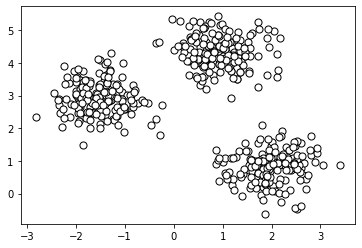

In [3]:
plt.scatter(X_blob[:,0],X_blob[:,1],
            c='white', marker='o', edgecolor='black', s=50)
plt.show()

In [4]:
km_blob = KMeans(n_clusters = 3,  #3 clusters
            init= 'random',  # random initialization
            n_init= 10, # number of re-iterations
            max_iter= 300, # max number of iteration per run
            tol= 1e-4, # minimum increase 10^(-4)
            random_state=0)
y_km_blob = km_blob.fit_predict(X_blob)
print(y_km_blob[:10]) # First 10 clusterized points
np.unique(y_km_blob)

[2 1 1 2 2 2 2 1 1 2]


array([0, 1, 2])

We can access to the following attributes:
- **cluster_centers_** : K x D -> Coordinates of cluster centers.
- **labels_** : N x 1 -> Labels of each point
- **inertia_** : float -> Sum of squared distances of samples to their closest cluster center.

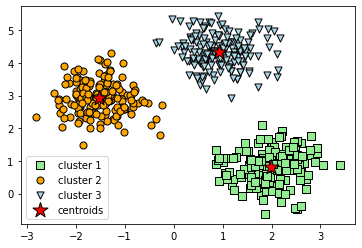

In [5]:
plt.scatter(X_blob[y_km_blob == 0,0], X_blob[y_km_blob == 0,1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
plt.scatter(X_blob[y_km_blob == 1,0], X_blob[y_km_blob == 1,1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
plt.scatter(X_blob[y_km_blob == 2,0], X_blob[y_km_blob == 2,1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')
plt.scatter(km_blob.cluster_centers_[:,0],km_blob.cluster_centers_[:,1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='centroids')
plt.legend(scatterpoints=1)

plt.show()

## A smarter way of placing the initial cluster centroids using k-means++

Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids. As a result, the computation is often done several times, with different initializations of the centroids and we keep the best solution in terms of inertia. 

A further method to help address this issue is the k-means++ initialization scheme, which has been implemented in Scikit-learn (use the init='k-means++' parameter). This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization.

**Algorithm**:
1) Take one centroid $c_1$, chosen uniformly at random from the dataset
2) Take a new centroid $c_i$, choosing an instance $x_i$ with probability $D(x_i)^2/ \sum_{j}D(x_j)^2$  where $D(x_i)^2$ is the distance between the instance $x_i$ and the closest selected centroid. 
3. Repeat the previous step until all $k$ centroids have been chosen.

In [6]:
km_blob = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km_blob = km_blob.fit_predict(X_blob)

Another important variant of the K-Means algorithm uses mini-batches. This speeds up the algorithm by a factor of three or four and makes it possible to cluster huge datasets that do not fit in memory. SKL implements it in the **MiniBatchKMeans** class.

## Using the elbow method to find the optimal number of clusters
To quantify the quality of the clustering we use intrinsic metrics such as the inertia. In Scikit-learn the inertia is available by the attribute **inertia_**. 

In [7]:
print('Distortion: %.2f' % km_blob.inertia_)

Distortion: 238.42


The inertia is not a good performance metric when choosing k because it keeps getting lower as we increase k. Indeed, the more clusters there are, the closer each
instance will be to its closest centroid, and therefore the lower the inertia will be.

We can plot the inertia as function of the number of clusters. We identify the value of $k$ wheere the distortion begins to increase most rapidly. 

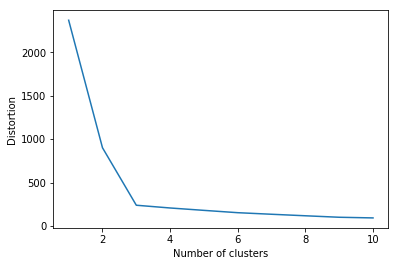

In [8]:
distortions = []
for i in np.arange(1,11):
    km = KMeans(n_clusters= i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X_blob)
    distortions.append(km.inertia_)
   
plt.plot(np.arange(1,11),distortions)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<br>

## Quantifying the quality of clustering  via silhouette plots

When the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

**a:** The mean distance between a sample and all other points in the same class.
**b**: The mean distance between a sample and all other points in the next nearest cluster.
The Silhouette Coefficient s for a single sample is then given as:

$$ s(i) = \frac{b(i) - a(i)}{max(a(i),b(i))} $$

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample. 

The Silhouette Coefficient can vary between –1 and +1. A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to –1 means that the instance may have been assigned to the wrong cluster.

The sihloutte coefficient for each sample is computed by the function **silhoutte_samples** and it is on the basis of the *silhoutte diagram*.

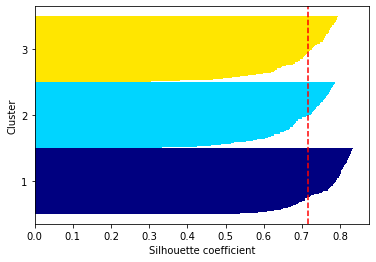

In [8]:
cluster_labels = np.unique(km_blob.labels_) #array of labe
n_clusters =  len(cluster_labels) #number of clusters
silhouette_vals =  silhouette_samples(X_blob, km_blob.labels_, metric='euclidean')# silhoutte for each sample
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels): # for each cluster
    c_silhouette_vals = silhouette_vals[y_km_blob == c] #get the s(i) for samples of cluster c
    c_silhouette_vals.sort() #sort in-place the s(i)
    y_ax_upper += len(c_silhouette_vals)
    color = mp.cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.show()

Comparison to "bad" clustering:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


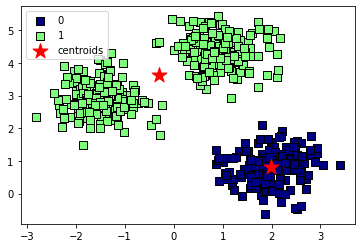

In [11]:
num_clusters = 2
km_bad = KMeans(n_clusters= num_clusters,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km_bad = km_bad.fit_predict(X_blob)

for i, c in enumerate(np.unique(km_bad.labels_)):
    plt.scatter(X_blob[y_km_bad == c, 0],
            X_blob[y_km_bad == c, 1],
            s=50,
            c=mp.cm.jet(i/num_clusters),
            edgecolor='black',
            marker='s',
            label=str(c))

plt.scatter(km_bad.cluster_centers_[:, 0], km_bad.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.show()

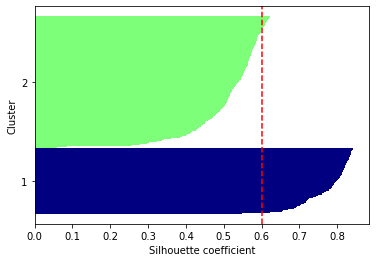

In [12]:
cluster_labels = np.unique(y_km_bad)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_blob, y_km_bad, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km_bad == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = mp.cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.show()

When most of the instances in a cluster have a lower coefficient than the silhoutte score, then the cluster is rather bad since this means its instances are much too close to other clusters.

# Organizing clusters as a hierarchical tree

Hierarchical clustering allows us to plot dendograms which help with the interpretation of the results; and we do not need to specify the number of clusters up front.

Approaches:
- agglomerative: merge the closest pairs of clusters
- divisive: sequence of splits

**Single linkage:** compute the distance between the most similar members of the clusters and merge the two clusters for which the most similar members is the smallest

**Complete linkage:** similar to the previous one but we compare the most dissimilar two members.

### Applying agglomerative clustering via scikit-learn

In [12]:
ac = AgglomerativeClustering(n_clusters=3, #how many clusters
                             affinity='euclidean', #which distance
                             linkage='complete')
y_ac_blob = ac.fit_predict(X_blob)

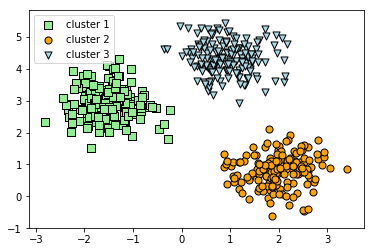

In [13]:
plt.scatter(X_blob[y_ac_blob == 0, 0],
            X_blob[y_ac_blob== 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
plt.scatter(X_blob[y_ac_blob == 1, 0],
            X_blob[y_ac_blob == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
plt.scatter(X_blob[y_ac_blob == 2, 0],
            X_blob[y_ac_blob == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')

plt.legend()
plt.show()

### Plot the dendogram

In [14]:
#toy example to show how children_ works
test = np.array([1,2,4,15,17,20]).reshape(-1,1)
test_ac = AgglomerativeClustering(n_clusters=2,
                                 affinity='euclidean',
                                 linkage='complete')
test_ac.fit(test)
test_ac.children_

array([[0, 1],
       [3, 4],
       [2, 6],
       [5, 7],
       [8, 9]])

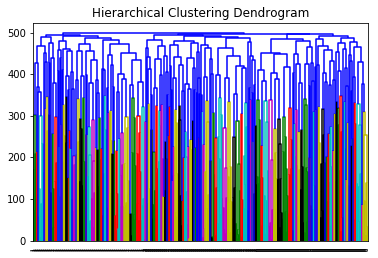

In [15]:
def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(ac, labels=ac.labels_)
plt.show()

# Locating regions of high density via DBSCAN
The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples).

**Algorithm**:
1) For each instance, the algorithm counts how many instances are located within a small distance **eps** (epsilon) from it. This region is called the instance’s $\epsilon$-neighborhood.
2) If an instance has at least **min_samples** instances in its $\epsilon$-neighborhood - including itself -, then it is considered a **core instance**. In other words, core instances are those that are located in dense regions.
3) All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.

There are two parameters to the algorithm, **min_samples** and **eps**, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

While the parameter **min_samples** primarily controls how tolerant the algorithm is towards noise (on noisy and large data sets it may be desiable to increase this parameter), the parameter eps is crucial to choose appropriately for the data set and distance function, and usually cannot be left at the default value. It controls the local neighborhood of the points. When chosen too small, most data will not be clustered at all (and labeled as -1 for “noise”). When chosen too large, it causes close clusters to be merged into one cluster, and eventually the entire data set to be returned as a single cluster. 

![](dbscan_type_points.png)

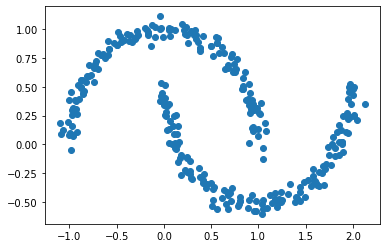

In [13]:
X_moon, y_moon = make_moons(n_samples=300, noise=0.05, random_state=0)
plt.scatter(X_moon[:,0],X_moon[:,1])
plt.show()

K-means and hierarchical clustering:

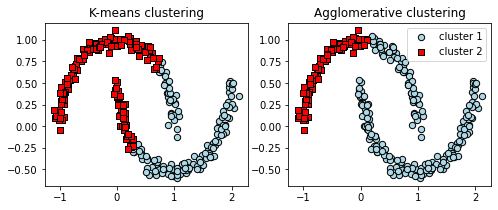

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km_moon = KMeans(n_clusters=2, random_state=0)
y_km_moon = km_moon.fit_predict(X_moon)
ax1.scatter(X_moon[y_km_moon == 0, 0], X_moon[y_km_moon == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X_moon[y_km_moon == 1, 0], X_moon[y_km_moon == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac_moon = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
y_ac_moon = ac_moon.fit_predict(X_moon) 
ax2.scatter(X_moon[y_ac_moon == 0, 0], X_moon[y_ac_moon == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X_moon[y_ac_moon == 1, 0], X_moon[y_ac_moon == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.show()

Density-based clustering:

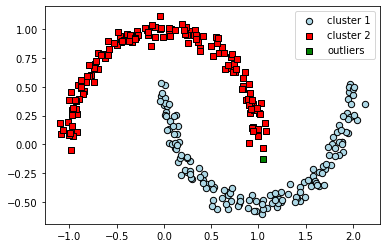

In [15]:
db_moon = DBSCAN(eps=0.150,
                 min_samples=4, 
                 metric='euclidean')
y_db_moon = db_moon.fit_predict(X_moon)
plt.scatter(X_moon[y_db_moon == 0, 0], X_moon[y_db_moon == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='cluster 1')
plt.scatter(X_moon[y_db_moon == 1, 0], X_moon[y_db_moon == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='cluster 2')
plt.scatter(X_moon[y_db_moon == -1, 0], X_moon[y_db_moon == -1, 1],
            c='green', marker='s', s=40,
            edgecolor='black', 
            label='outliers')
plt.legend()
plt.show()

### k-distance graph to choose eps
From the original DBSCAN paper: "However, our experiments indicate that the k-dist graphs for k > 4 do not significantly differ from the 4-dist graph and, furthermore, they need considerably more computation. Therefore, we eliminate the parameter MinPts by setting it to 4 for all databases. "

To identify a good value for **eps**, we compute the distance of every point to its 4th nearest neighbor.
These 4-distances are plotted in an ascending order. 
The aim is to determine the **knee**, if exists, which corresponds to the optimal eps parameter.

To compute the 4-distances we use the class NearestNeighbors.

In [16]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X_moon)
distances, indices = nbrs.kneighbors(X_moon)

In [17]:
four_distances = np.sort(distances[:,-1])

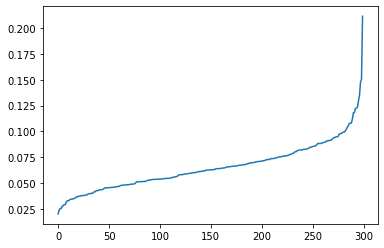

In [18]:
plt.plot(np.arange(len(four_distances)),four_distances)

### Evaluating clustering with a ground truth

Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations.

Assume two label assignments (of the same N objects), $U$  and $V$ . The mutual information (MI) between $U$ and $V$ is calculated by:

$$ \text{MI}(U, V) = \sum_{i=1}^{|U|}\sum_{j=1}^{|V|}P(i, j)\log\left(\frac{P(i,j)}{P(i)P'(j)}\right) = \sum_{i=1}^{|U|} \sum_{j=1}^{|V|} \frac{|U_i \cap V_j|}{N}\log\left(\frac{N|U_i \cap V_j|}{|U_i||V_j|}\right)$$

The normalized mutual information is defined as

$$ \text{NMI}(U, V) = \frac{\text{MI}(U, V)}{\text{mean}(H(U), H(V))} $$

In Scikit-learn the NMI is computed by the function **normalized_mutual_info_score**

In [19]:
# compute NMI for the moon datasets
normalized_mutual_info_score(y_moon, y_db_moon)

0.9857611824162716